In [23]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
from math import exp, sqrt, pi
from scipy.optimize import fsolve
from scipy.special import erf, erfc
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

with open('variabler.pkl', 'rb') as f:
    countries, ALP1, ALP2, ALP3, MDY, SY, RHO, SE, BSY, DY = pickle.load(f)

In [24]:
per     = 4
r       = 0.152335822311631
cas_    = 1
Gs1_initial_guess = -1
num_points = 1000

values = list(ALP1.values())
ncount = len(ALP1)
XX = np.zeros((ncount, 4))
XX[:, 0] = 0.04
XX[:, 1] = 0.045
XX[:, 2] = 0.05
XX[:, 3] = values
XX = XX.T

df = pd.DataFrame(XX.T, columns=['0', '1', '2', '3'])
df.index = ALP1.keys()

In [25]:
def solve_iid(z, sigma):
    cdf = (1 + erf(z / sqrt(2))) / 2
    pdf = exp(-z**2 / 2) / sqrt(2 * pi)
    res = sigma * (1 - cdf) - pdf
    return res

In [26]:
alpha = {}
seg = {}
gbar1 = {}
gbar = {}
Gs1_so = {}
F1 = {}
EBn = {}
EBe = {}
EBm = {}
EDm = {}
Ez = {}
EFm = {}
EFd = {}
resd = {}
resd = np.zeros((ncount, 4))  # Anta n_rows er definert på forhånd
tmpm = np.zeros((ncount, 3))
tmpb = np.zeros((ncount, 3))
D = {}
Fm = [[] for _ in range(ncount)]
Laffer = [[] for _ in range(ncount)]
T_0_new = 1980
T_new = 2010
smpl1 = [year for year in range(T_0_new, T_new + 1)]
ALP = {}
BSYobs = {}
DATA = []
resm = []  
resb = []  

for j in range(0, len(XX)):

    ALP1 = df.T.iloc[j]

    for i in range(0, len(ALP1)):

        alpha[countries[i]] = ALP1[countries[i]]
        seg[countries[i]] = SY[countries[i]]
        gbar1[countries[i]] = np.log(1+MDY[countries[i]])
        gbar[countries[i]] = per * gbar1[countries[i]]

        Gs1_so[countries[i]] = fsolve(lambda Gs1: solve_iid(Gs1, seg[countries[i]]), Gs1_initial_guess)
        
        F1[countries[i]] = (1+erf(Gs1_so[countries[i]]/sqrt(2)))/2

        EBn[countries[i]] = alpha[countries[i]] * exp(gbar[countries[i]] +seg[countries[i]]*Gs1_so[countries[i]]) * (1-F1[countries[i]])/(1+r)
        
        EBe[countries[i]] = alpha[countries[i]] * exp(gbar[countries[i]]+seg[countries[i]]*seg[countries[i]]/2)/(1+r-exp(gbar[countries[i]]+seg[countries[i]]*seg[countries[i]]/2))

        if EBe[countries[i]] < 0:
            EBe[countries[i]]=math.inf

        EBm[countries[i]] = alpha[countries[i]] * exp(gbar[countries[i]] + seg[countries[i]] * Gs1_so[countries[i]]) * (1 - F1[countries[i]]) / (1 + r - exp(gbar[countries[i]] + seg[countries[i]] * Gs1_so[countries[i]]) * (1 - F1[countries[i]]))

        EDm[countries[i]] = exp(gbar[countries[i]]+seg[countries[i]]*Gs1_so[countries[i]])*(alpha[countries[i]]+EBm[countries[i]])

        Ez[countries[i]]  = (np.log(EDm[countries[i]]/(alpha[countries[i]]+EBm[countries[i]]))-gbar[countries[i]])/seg[countries[i]]
        
        EFm[countries[i]] = 1-(1-(1+erf(Ez[countries[i]]/sqrt(2)))/2) ** (1/per)

        # Ez[countries[i]] = (np.log(0.01*BSY[countries[i]]/(alpha[countries[i]]+per*EBm[countries[i]]))-gbar1[countries[i]])/(seg[countries[i]]/per)
        
        Ez[countries[i]] = (np.log(0.01*(BSY[countries[i]].iloc[-1]/per)/(alpha[countries[i]]+EBm[countries[i]]))-gbar[countries[i]])/(seg[countries[i]])
        
        if np.all(np.imag(Ez[countries[i]]) == 0):
            EFd[countries[i]] = 1-(1-(1+erf(Ez[countries[i]]/sqrt(2)))/2) ** (1/per)
        else:
            EFd[countries[i]]=np.nan

        # Der er noget galt her
        resd[i, 0] = 100 * alpha[countries[i]]
        resd[i, 1] = 100 * gbar[countries[i]] / 4
        resd[i, 2] = 100 * SY[countries[i]]
        resd[i, 3] = BSY[countries[i]].iloc[-1]

        tmpm[i, 0] = 100 * per * EDm[countries[i]]
        tmpm[i, 1] = 100 * EFm[countries[i]]
        tmpm[i, 2] = 100 * EFd[countries[i]]

        tmpb[i, 0] = 100 * per * EBn[countries[i]]
        tmpb[i, 1] = 100 * EBm[countries[i]]
        tmpb[i, 2] = 100 * per * EBe[countries[i]]

        D[countries[i]] = np.linspace(0.8 * EDm[countries[i]], 1.8 * EDm[countries[i]], num_points)
        
        #Ez[countries[i]] = (np.log(per*D[countries[i]]/(alpha[countries[i]]+per[countries[i]]*EBm[countries[i]]))-gbar1[countries[i]])/(seg[countries[i]]/per[countries[i]])
        Ez[countries[i]] = (np.log(D[countries[i]]/(alpha[countries[i]]+EBm[countries[i]]))-gbar[countries[i]])/(seg[countries[i]])

        Fm[i].extend([per * D[countries[i]], 1 - (1 - (1 + erf(Ez[countries[i]]/np.sqrt(2)))/2)**(1/per)])
        Laffer[i].extend([D[countries[i]]*(1-(1-(1+erf(Ez[countries[i]]/sqrt(2)))/2))/(1+r)])

        ALP[countries[i]] = alpha[countries[i]]
        BSYobs[countries[i]]  = 0.01*BSY[countries[i]][(BSY[countries[i]].index >= T_0_new) & (BSY[countries[i]].index <= T_new)]/per
        seg[countries[i]] = SY[countries[i]]
        gbar1[countries[i]] = np.log(1+MDY[countries[i]])
        gbar[countries[i]] = per * gbar1[countries[i]]
        
        Gs1_so[countries[i]] = fsolve(lambda Gs1: solve_iid(Gs1, seg[countries[i]]), Gs1_initial_guess)
        F1[countries[i]] = (1+erf(Gs1_so[countries[i]]/sqrt(2)))/2

        EBm[countries[i]] = []
        Ez[countries[i]] = [0] * len(smpl1)     
        EFd[countries[i]] = [0] * len(smpl1)     

        for t in range(0,len(smpl1)):
            EBm[countries[i]].append(ALP[countries[i]] * exp(gbar[countries[i]] + seg[countries[i]] * Gs1_so[countries[i]]) * (1-F1[countries[i]]) / (1 + r - exp(gbar[countries[i]] + seg[countries[i]] * Gs1_so[countries[i]]) * (1-F1[countries[i]])))
        
         #  Ez[countries[i]] = (np.log(BSYobs[countries[i]][T_0_new+t]/(ALP[countries[i]]+per*EBm[countries[i]][t]))-gbar1[countries[i]])/(seg[countries[i]]/per)
            Ez[countries[i]][t] = (np.log(BSYobs[countries[i]].values[t] / (ALP[countries[i]] + EBm[countries[i]][t])) - gbar[countries[i]]) / (seg[countries[i]])

            if np.all(np.imag(Ez[countries[i]][t]) == 0):
                EFd[countries[i]][t] = 1-(1-(1+erf(Ez[countries[i]][t]/sqrt(2)))/2) ** (1/per)
            else:
                EFd[countries[i]][t]=np.nan
        
            EFd[countries[i]][t] = 100 * EFd[countries[i]][t]

        DATA.append((np.arange(T_0_new, T_new + 1), 100 * per * (BSYobs[countries[i]].values - EDm[countries[i]]), EFd[countries[i]]))

    resm.append(tmpm.copy()) 
    
    resb.append(tmpb.copy()) 


In [27]:
dfs = []
alphas = [0.04, 0.045, 0.05, 0] 

for i in range(len(resm)):
    dff = pd.DataFrame(resm[i])
    suffixes = [f"EDm (a={alphas[i]})", f"EFm (a={alphas[i]})", f"EFd (a={alphas[i]})"]
    dff.columns = suffixes  
    dfs.append(dff)

    df_merged = dfs[0]
    for i in range(1, len(dfs)):
        df_merged = df_merged.join(dfs[i], how='right')
        df_merged = df_merged.round(3)

    df_resm = df_merged

df_resm.index = [countries[i] for i in range(len(countries))]
df_resm

EDm (a=0.04)  EFm (a=0.04)  EFd (a=0.04)  EDm (a=0.045)  \
Australia            114.551         0.312         0.000        128.870   
Austria              117.050         0.350         0.000        131.682   
Belgium              106.982         0.356         0.001        120.355   
Canada                97.324         0.400         0.000        109.489   
Denmark               94.253         0.435         0.000        106.035   
Finland               88.945         0.610         0.000        100.063   
France               118.031         0.307         0.000        132.785   
Germany              104.904         0.375         0.000        118.017   
Greece                72.183         0.701       100.000         81.206   
Hungary               92.678         0.508         0.000        104.263   
Iceland               89.578         0.611        69.773        100.775   
Ireland              123.830         0.563         0.000        139.309   
Italy                 91.275         0.449        88.215        102.684   
Korea                231.072         0.793         0.000        259.956   
Netherlands          110.679         0.323         0.000        124.514   
New Zealand           80.939         0.448         0.000         91.056   
Norway               143.459         0.262         0.000        161.391   
Portugal              87.825         0.637         0.051         98.803   
Spain                116.192         0.318         0.000        130.716   
Sweden                93.620         0.434         0.000        105.322   
Switzerland           82.677         0.399         0.000         93.012   
United Kingdom       101.771         0.407         0.000        114.492   
United States         97.449         0.407         0.010        109.630   

                EFm (a=0.045)  EFd (a=0.045)  EDm (a=0.05)  EFm (a=0.05)  \
Australia               0.312          0.000       143.189         0.312   
Austria                 0.350          0.000       146.313         0.350   
Belgium                 0.356          0.000       133.728         0.356   
Canada                  0.400          0.000       121.655         0.400   
Denmark                 0.435          0.000       117.817         0.435   
Finland                 0.610          0.000       111.181         0.610   
France                  0.307          0.000       147.539         0.307   
Germany                 0.375          0.000       131.130         0.375   
Greece                  0.701         99.854        90.229         0.701   
Hungary                 0.508          0.000       115.848         0.508   
Iceland                 0.611         22.874       111.972         0.611   
Ireland                 0.563          0.000       154.787         0.563   
Italy                   0.449         34.844       114.094         0.449   
Korea                   0.793          0.000       288.840         0.793   
Netherlands             0.323          0.000       138.349         0.323   
New Zealand             0.448          0.000       101.174         0.448   
Norway                  0.262          0.000       179.324         0.262   
Portugal                0.637          0.000       109.781         0.637   
Spain                   0.318          0.000       145.240         0.318   
Sweden                  0.434          0.000       117.025         0.434   
Switzerland             0.399          0.000       103.347         0.399   
United Kingdom          0.407          0.000       127.213         0.407   
United States           0.407          0.000       121.812         0.407   

                EFd (a=0.05)  EDm (a=0)  EFm (a=0)  EFd (a=0)  
Australia              0.000    119.273      0.312      0.000  
Austria                0.000     97.178      0.350      0.000  
Belgium                0.000    182.866      0.356      0.000  
Canada                 0.000    244.526      0.400      0.000  
Denmark                0.000    167.287      0.435      0.000  
Finlan

In [28]:
dfs = []
alphas = [0.04, 0.045, 0.05, 0]  

for i in range(len(resb)):
    dff = pd.DataFrame(resb[i])
    suffixes = [f"EDm (a={alphas[i]})", f"EFm (a={alphas[i]})", f"EFd (a={alphas[i]})"]
    dff.columns = suffixes  
    dfs.append(dff)

    df_merged = dfs[0]
    for i in range(1, len(dfs)):
        df_merged = df_merged.join(dfs[i], how='right')
        df_merged = df_merged.round(3)

    df_resb = df_merged

df_resb.index = [countries[i] for i in range(len(countries))]
df_resb       

# FEJL FOR ALLE EFm 

EDm (a=0.04)  EFm (a=0.04)  EFd (a=0.04)  EDm (a=0.045)  \
Australia             13.758        24.543       238.677         15.478   
Austria               13.796        25.041       286.656         15.521   
Belgium               13.619        22.882       234.162         15.322   
Canada                13.417        20.779       213.180         15.094   
Denmark               13.344        20.095       216.806         15.012   
Finland               13.197        18.830       302.765         14.846   
France                13.815        25.294       251.628         15.542   
Germany               13.578        22.420       236.882         15.275   
Greece                12.671        15.226       198.755         14.255   
Hungary               13.300        19.701       253.358         14.962   
Iceland               13.213        18.963       312.005         14.865   
Ireland               13.885        26.265      1879.279         15.621   
Italy                 13.271        19.449       207.903         14.930   
Korea                 14.782        48.560           inf         16.630   
Netherlands           13.690        23.703       229.331         15.401   
New Zealand           12.988        17.247       159.139         14.611   
Norway                14.161        30.798       335.767         15.931   
Portugal              13.165        18.573       315.336         14.810   
Spain                 13.785        24.889       251.275         15.508   
Sweden                13.329        19.961       212.746         14.995   
Switzerland           13.044        17.652       150.988         14.675   
United Kingdom        13.512        21.722       242.484         15.201   
United States         13.419        20.800       217.733         15.097   

                EFm (a=0.045)  EFd (a=0.045)  EDm (a=0.05)  EFm (a=0.05)  \
Australia              27.611        268.511        17.197        30.679   
Austria                28.171        322.488        17.245        31.301   
Belgium                25.742        263.433        17.024        28.602   
Canada                 23.376        239.827        16.771        25.974   
Denmark                22.607        243.907        16.680        25.119   
Finland                21.184        340.610        16.496        23.538   
France                 28.455        283.081        17.269        31.617   
Germany                25.222        266.492        16.972        28.025   
Greece                 17.129        223.600        15.839        19.032   
Hungary                22.164        285.027        16.625        24.627   
Iceland                21.333        351.005        16.516        23.704   
Ireland                29.548       2114.189        17.357        32.831   
Italy                  21.880        233.891        16.588        24.311   
Korea                  54.629            inf        18.478        60.699   
Netherlands            26.666        257.997        17.112        29.629   
New Zealand            19.403        179.032        16.235        21.559   
Norway                 34.648        377.738        17.701        38.498   
Portugal               20.895        354.753        16.456        23.216   
Spain                  28.000        282.685        17.231        31.112   
Sweden                 22.456        239.339        16.661        24.951   
Switzerland            19.859        169.861        16.305        22.065   
United Kingdom         24.437        272.795        16.890        27.152   
United States          23.400        244.949        16.774        26.000   

                EFd (a=0.05)  EDm (a=0)  EFm (a=0)  EFd (a=0)  
Australia            298.346     14.325     25.555    248.515  
Austria              358.320     11.454     20.789    237.987  
Belgium              292.703     23.279     39.112    400.257  
Canada               266.474     33.711     52.207    535.614  
Denmark              271.008     23.684     35.666    384.802  
Finlan

In [29]:
dataframes = {}
combined_df = {}

for i in range(92):
    dff = pd.DataFrame({'Year': DATA[i][0], 'EDm': DATA[i][1], 'EFd': [item[0] for item in DATA[i][2]]})
    dataframes[i] = dff

for i in range(23):
    temp_df = dataframes[i].merge(dataframes[i+23], how='right', on="Year", suffixes=(' (a = 0.04)', ' (a_1 = 0.045)'))
    temp_df = temp_df.merge(dataframes[i+23+23], how='right', on="Year", suffixes=(' (a_1 = 0.045)', ' (a_2 = 0.05)'))
    temp_df = temp_df.merge(dataframes[i+23+23+23], how='right', on="Year", suffixes=(' (a_2 = 0.05)', ' (a_3 = a)'))
    temp_df = temp_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    temp_df = temp_df.round(3)
    combined_df[countries[i]] = temp_df

combined_df[countries[0]]

Year  EDm (a = 0.04)  EFd (a = 0.04)  EDm (a_1 = 0.045)  \
0   1980         -95.851             0.0            -110.17   
1   1981         -98.751             0.0            -113.07   
2   1982         -99.851             0.0            -114.17   
3   1983         -97.351             0.0            -111.67   
4   1984         -94.951             0.0            -109.27   
5   1985         -93.651             0.0            -107.97   
6   1986         -93.551             0.0            -107.87   
7   1987         -95.051             0.0            -109.37   
8   1988         -98.551             0.0            -112.87   
9   1989        -102.351             0.0            -116.67   
10  1990        -104.551             0.0            -118.87   
11  1991        -105.451             0.0            -119.77   
12  1992        -103.951             0.0            -118.27   
13  1993        -101.051             0.0            -115.37   
14  1994         -99.051             0.0            -113.37   
15  1995         -96.651             0.0            -110.97   
16  1996         -97.251             0.0            -111.57   
17  1997         -97.551             0.0            -111.87   
18  1998        -100.351             0.0            -114.67   
19  1999        -101.751             0.0            -116.07   
20  2000        -103.751             0.0            -118.07   
21  2001        -105.551             0.0            -119.87   
22  2002        -106.551             0.0            -120.87   
23  2003        -107.751             0.0            -122.07   
24  2004        -108.451             0.0            -122.77   
25  2005        -108.851             0.0            -123.17   
26  2006        -109.351             0.0            -123.67   
27  2007        -109.851             0.0            -124.17   
28  2008        -110.051             0.0            -124.37   
29  2009        -105.251             0.0            -119.57   
30  2010        -103.251             0.0            -117.57   

    EFd (a_1 = 0.045)  EDm (a_2 = 0.05)  EFd (a_2 = 0.05)  EDm (a_3 = a)  \
0                 0.0          -124.489               0.0       -100.573   
1                 0.0          -127.389               0.0       -103.473   
2                 0.0          -128.489               0.0       -104.573   
3                 0.0          -125.989               0.0       -102.073   
4                 0.0          -123.589               0.0        -99.673   
5                 0.0          -122.289               0.0        -98.373   
6                 0.0          -122.189               0.0        -98.273   
7                 0.0          -123.689               0.0        -99.773   
8                 0.0          -127.189               0.0       -103.273   
9                 0.0          -130.989               0.0       -107.073   
10                0.0          -133.189               0.0       -109.273   
11                0.0          -134.089               0.0       -110.173   
12                0.0          -132.589               0.0       -108.673   
13                0.0          -129.689               0.0       -105.773   
14                0.0          -127.689               0.0       -103.773   
15                0.0          -125.289               0.0       -101.373   
16                0.0          -125.889               0.0       -101.973   
17                0.0          -126.189               0.0       -102.273   
18                0.0          -128.989               0.0       -105.073   
19                0.0          -130.389               0.0       -106.473   
20                0.0          -132.389               0.0       -108.473   
21                0.0          -134.189               0.0       -110.273   
22                0.0          -135.189               0.0       -111.273   
23                0.0          -136.389               0.0       -112.473   
24                0.0          -137.089               0.0       -113.173   
25         

*****
*****
*****

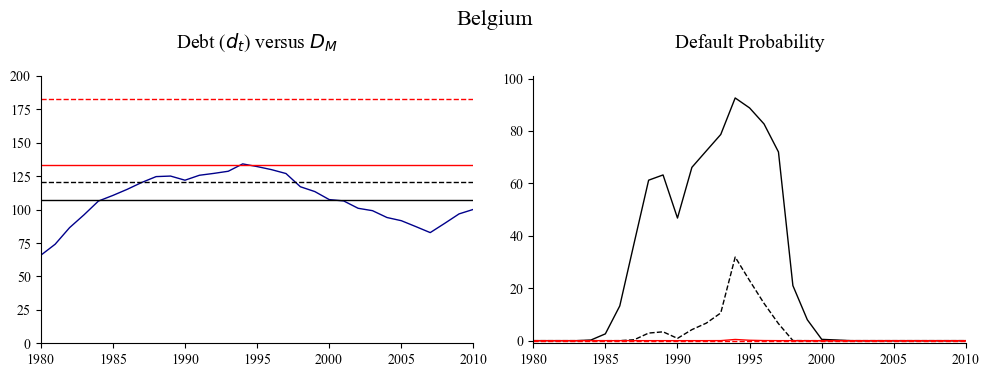

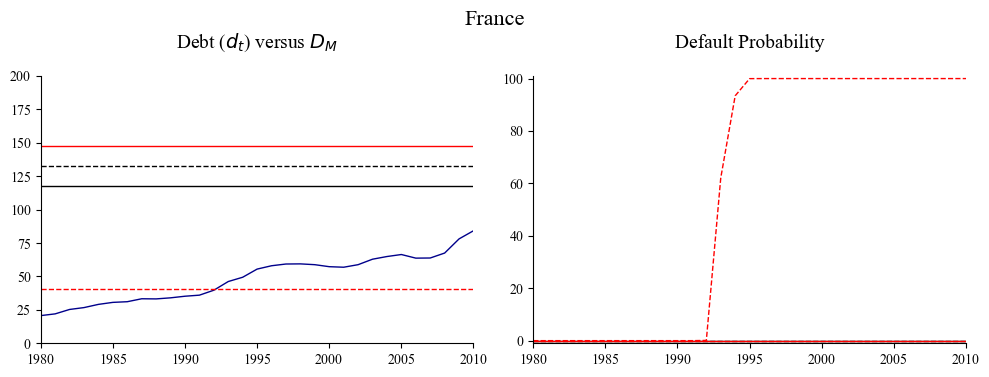

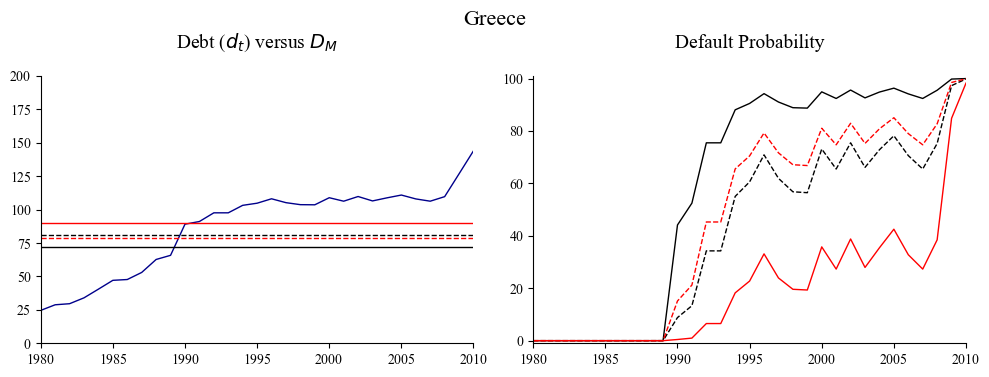

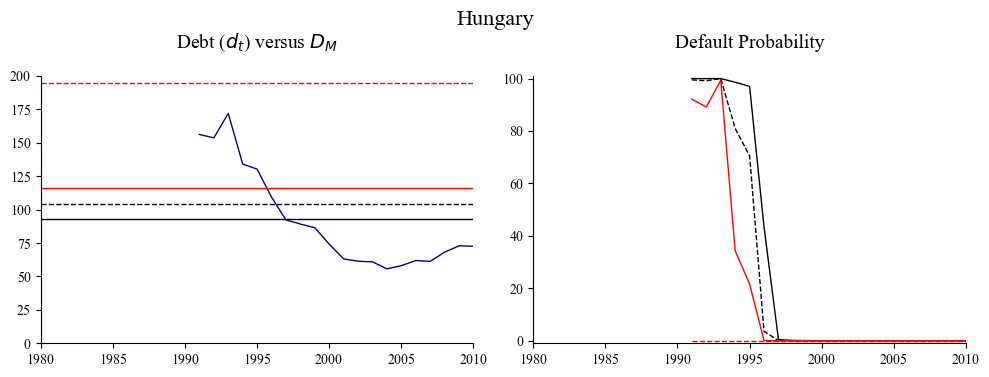

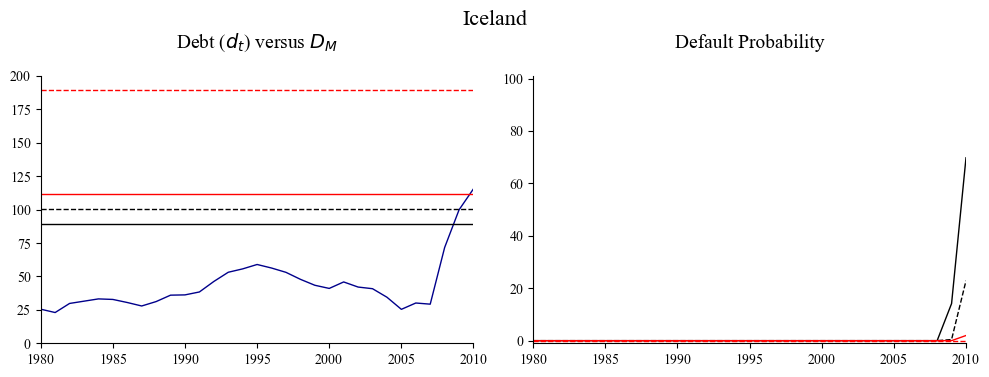

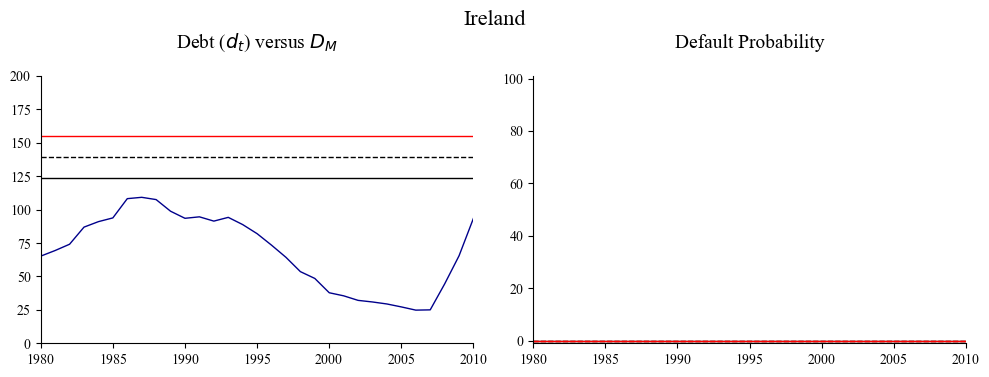

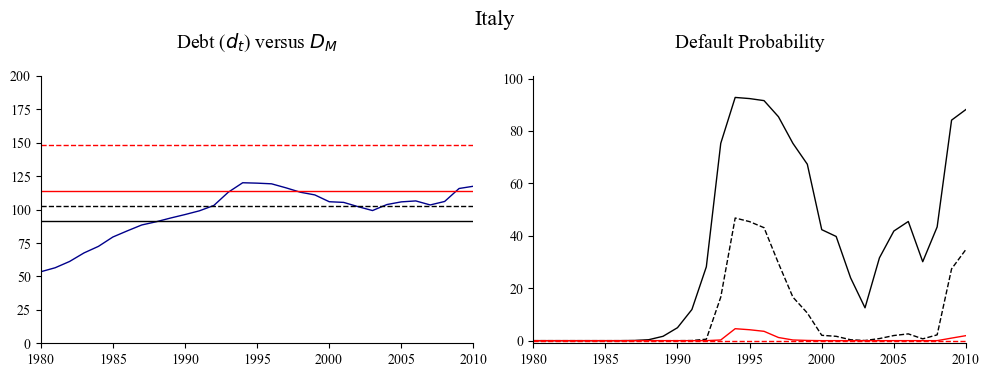

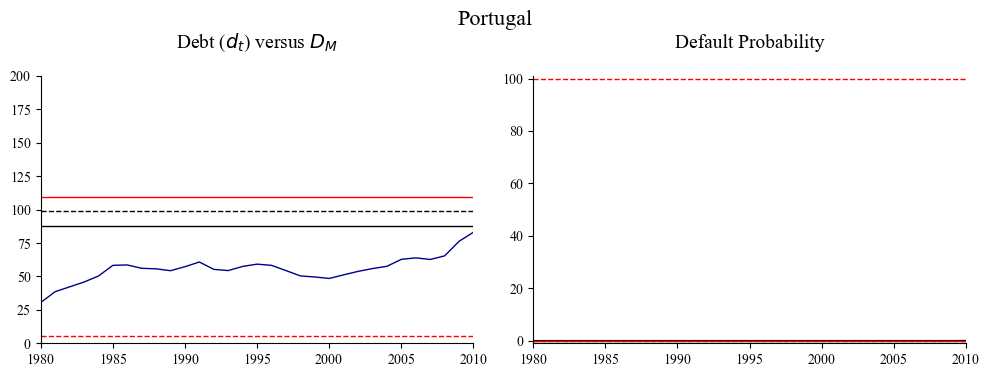

In [30]:
BSY_plot = {}
for i in range(0, len(countries)):
    BSY_plot[countries[i]] = BSY[countries[i]][(BSY[countries[i]].index >= T_0_new) & (BSY[countries[i]].index <= T_new)]

for i in [2,6,8,9,10,11,12,17]: # range(0, len(countries)): #
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(combined_df[countries[i]]["Year"], BSY_plot[countries[i]], color='darkblue', linestyle='-',linewidth=1)
    #axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["EDm (a = 0.04)"], color='darkblue', linestyle='-',linewidth=1)
    axs[0].axhline(y=df_resm.loc[countries[i], 'EDm (a=0.04)'] , color='black', linestyle='-',linewidth=1)
    axs[0].axhline(y=df_resm.loc[countries[i], 'EDm (a=0.045)'] , color='black', linestyle='--',linewidth=1)
    axs[0].axhline(y=df_resm.loc[countries[i], 'EDm (a=0.05)'] , color='red', linestyle='-',linewidth=1)
    axs[0].axhline(y=df_resm.loc[countries[i], 'EDm (a=0)'], color='red', linestyle='--', linewidth=1)
    
    # Slå nedstående til hvis BSY_plot benyttes
    axs[0].set_ylim(0, 200)
    
    axs[0].set_xlim(T_0_new, T_new)
    axs[0].set_title("Debt ($d_t$) versus $D_M$", fontname='Times New Roman', size=14, pad=20)
    axs[0].tick_params(axis='x', labelsize=10)
    axs[0].tick_params(axis='y', labelsize=10)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['right'].set_color('none')
    axs[0].yaxis.tick_left()
    axs[0].spines['bottom'].set_position('zero')
    axs[0].spines['top'].set_color('none')
    axs[0].xaxis.tick_bottom()

    for label in axs[0].get_yticklabels():
        label.set_fontproperties(font_props)

    # Tilsvarende kan du gøre for x-aksen
    for label in axs[0].get_xticklabels():
        label.set_fontproperties(font_props)

    axs[1].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["EFd (a = 0.04)"], label='EFd (a = 0.04)',  color='black', linestyle='-',linewidth=1)
    axs[1].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["EFd (a_1 = 0.045)"], label='EFd (a = 0.045)' ,  color='black', linestyle='--',linewidth=1)
    axs[1].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["EFd (a_2 = 0.05)"], label='EFd (a = 0.05)',  color='red', linestyle='-',linewidth=1)
    axs[1].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["EFd (a_3 = a)"], label='EFd (a = 0)' ,  color='red', linestyle='--',linewidth=1)
    axs[1].set_title("Default Probability", fontname='Times New Roman', size=14)
    axs[1].tick_params(axis='x', labelsize=10)
    axs[1].tick_params(axis='y', labelsize=10)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_ylim(-1, 101)
    axs[1].set_xlim(T_0_new, T_new)

    # For hver tick label på y-aksen, anvend den ønskede font
    for label in axs[1].get_yticklabels():
        label.set_fontproperties(font_props)

    # Tilsvarende kan du gøre for x-aksen
    for label in axs[1].get_xticklabels():
        label.set_fontproperties(font_props)

    plt.title("Default Probability", fontname='Times New Roman', size=14, pad=20)
    fig.suptitle(f"{countries[i]}", fontname='Times New Roman', size=16, weight='normal', y=0.93)


    plt.tight_layout()
    plt.show()

In [31]:
for i in range(len(countries)):
    print(f"{countries[i]:15s} & {resd[i,0]:6.2f} & {resd[i,1]:6.2f} & {resd[i,2]:6.2f} & {resd[i,3]:6.2f} \\\\")

Australia       &   4.16 &   1.91 &   3.26 &  11.30 \\
Austria         &   3.32 &   2.17 &   3.60 &  70.00 \\
Belgium         &   6.84 &   1.88 &   3.65 & 100.20 \\
Canada          &  10.05 &   1.72 &   4.04 &  81.70 \\
Denmark         &   7.10 &   1.74 &   4.35 &  40.60 \\
Finland         &   9.82 &   2.21 &   5.82 &  50.00 \\
France          &   1.36 &   1.99 &   3.22 &  84.20 \\
Germany         &   4.34 &   1.89 &   3.82 &  78.80 \\
Greece          &   4.37 &   1.56 &   6.56 & 144.00 \\
Hungary         &   8.39 &   1.98 &   4.97 &  72.60 \\
Iceland         &   8.47 &   2.25 &   5.84 & 115.58 \\
Ireland         &   6.74 &   3.30 &   5.44 &  93.60 \\
Italy           &   6.51 &   1.67 &   4.47 & 117.50 \\
Korea           &   6.44 &   5.75 &   7.29 &  32.00 \\
Netherlands     &   5.62 &   1.84 &   3.36 &  67.40 \\
New Zealand     &   7.73 &   1.12 &   4.46 &  31.00 \\
Norway          &  20.25 &   2.37 &   2.80 &  54.30 \\
Portugal        &   0.23 &   2.26 &   6.04 &  83.10 \\
Spain     

In [32]:
fmt = '%15s ' + ' & '.join(['%6.2f' for _ in range(df_resm.shape[1])]) + ' \\\\'
for i in range(len(df_resm)):
    print(fmt % tuple([df_resm.index[i]] + list(df_resm.iloc[i])))

      Australia 114.55 &   0.31 &   0.00 & 128.87 &   0.31 &   0.00 & 143.19 &   0.31 &   0.00 & 119.27 &   0.31 &   0.00 \\
        Austria 117.05 &   0.35 &   0.00 & 131.68 &   0.35 &   0.00 & 146.31 &   0.35 &   0.00 &  97.18 &   0.35 &   0.00 \\
        Belgium 106.98 &   0.36 &   0.00 & 120.36 &   0.36 &   0.00 & 133.73 &   0.36 &   0.00 & 182.87 &   0.36 &   0.00 \\
         Canada  97.32 &   0.40 &   0.00 & 109.49 &   0.40 &   0.00 & 121.66 &   0.40 &   0.00 & 244.53 &   0.40 &   0.00 \\
        Denmark  94.25 &   0.43 &   0.00 & 106.03 &   0.43 &   0.00 & 117.82 &   0.43 &   0.00 & 167.29 &   0.43 &   0.00 \\
        Finland  88.94 &   0.61 &   0.00 & 100.06 &   0.61 &   0.00 & 111.18 &   0.61 &   0.00 & 218.28 &   0.61 &   0.00 \\
         France 118.03 &   0.31 &   0.00 & 132.78 &   0.31 &   0.00 & 147.54 &   0.31 &   0.00 &  40.25 &   0.31 & 100.00 \\
        Germany 104.90 &   0.38 &   0.00 & 118.02 &   0.38 &   0.00 & 131.13 &   0.38 &   0.00 & 113.74 &   0.38 &   0.00 \\


In [33]:
fmt = '%15s ' + ' & '.join(['%6.2f' for _ in range(df_resb.shape[1])]) + ' \\\\'
for i in range(len(df_resb)):
    print(fmt % tuple([df_resb.index[i]] + list(df_resb.iloc[i])))

      Australia  13.76 &  24.54 & 238.68 &  15.48 &  27.61 & 268.51 &  17.20 &  30.68 & 298.35 &  14.32 &  25.55 & 248.51 \\
        Austria  13.80 &  25.04 & 286.66 &  15.52 &  28.17 & 322.49 &  17.25 &  31.30 & 358.32 &  11.45 &  20.79 & 237.99 \\
        Belgium  13.62 &  22.88 & 234.16 &  15.32 &  25.74 & 263.43 &  17.02 &  28.60 & 292.70 &  23.28 &  39.11 & 400.26 \\
         Canada  13.42 &  20.78 & 213.18 &  15.09 &  23.38 & 239.83 &  16.77 &  25.97 & 266.47 &  33.71 &  52.21 & 535.61 \\
        Denmark  13.34 &  20.09 & 216.81 &  15.01 &  22.61 & 243.91 &  16.68 &  25.12 & 271.01 &  23.68 &  35.67 & 384.80 \\
        Finland  13.20 &  18.83 & 302.76 &  14.85 &  21.18 & 340.61 &  16.50 &  23.54 & 378.46 &  32.39 &  46.21 & 743.03 \\
         France  13.81 &  25.29 & 251.63 &  15.54 &  28.45 & 283.08 &  17.27 &  31.62 & 314.54 &   4.71 &   8.62 &  85.80 \\
        Germany  13.58 &  22.42 & 236.88 &  15.28 &  25.22 & 266.49 &  16.97 &  28.02 & 296.10 &  14.72 &  24.31 & 256.84 \\
